In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_raw.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_raw.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = TensorDataset(torch.FloatTensor(train_X).unsqueeze(1).contiguous(), torch.FloatTensor(train_y))
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(torch.FloatTensor(val_X).unsqueeze(1).contiguous(), torch.FloatTensor(val_y))
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

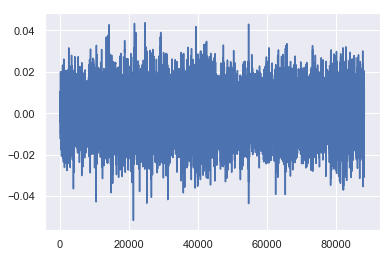

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_X[9])

In [5]:
# Raw Waveform-based Audio Classification Using Sample-level CNN Architectures
# https://arxiv.org/pdf/1712.00866.pdf

ConvBlock = lambda in_channels, out_channels: nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
)

class Dropout1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        return self.dropout(x.unsqueeze(-1)).squeeze(-1)

class ResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.process = nn.Sequential(
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels),
            nn.ReLU(),
            Dropout1d(),
            nn.Conv1d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(channels)            
        )
        
        self.gate = nn.Sequential(
            nn.Linear(channels, 2 * channels),
            nn.ReLU(),
            nn.Linear(2 * channels, channels),
            nn.Sigmoid()
        )
        
        self.postprocess = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3)
        )
        
    def forward(self, x):
        y = self.process(x)
        g = self.gate(x.mean(dim=-1))
        return self.postprocess(x + y * g[:, :, None])

class ReSE_2_Multi(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, stride=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
            ResBlock(64),
        )
        
        self.levels = 3
        self.head = nn.Linear(64 * self.levels, 80)
        
    def forward(self, x):
        x = self.convs[:-self.levels](x)
        
        last_features = []
        for module in self.convs[-self.levels:]:
            x = module(x)
            last_features.append(torch.max(x, dim=-1)[0])
            
        features = torch.cat(last_features, dim=1)
        
        return self.head(features)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = ReSE_2_Multi()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('ReSE_2_Multi_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [7]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=200, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.1254
   2, 0.2064
   3, 0.2877
   4, 0.3103
   5, 0.3302
   6, 0.3639
   7, 0.3686
   8, 0.4319
   9, 0.4379
  10, 0.4616
  11, 0.4715
  12, 0.4967
  14, 0.5039
  15, 0.5283
  16, 0.5379
  17, 0.5884
  21, 0.5985
  24, 0.6091
  29, 0.6224
  30, 0.6396
  34, 0.6464
  45, 0.6570
  47, 0.6596
  49, 0.6646
  52, 0.6872
Epoch    63: reducing learning rate of group 0 to 5.0000e-04.
  66, 0.6878
  72, 0.6884
  81, 0.6885
  82, 0.6909
Epoch    93: reducing learning rate of group 0 to 2.5000e-04.
Done.


In [8]:
epoch_time, best_loss

(25.42106928544886, 0.6909101237286492)

Text(0.5,1,'Logloss')

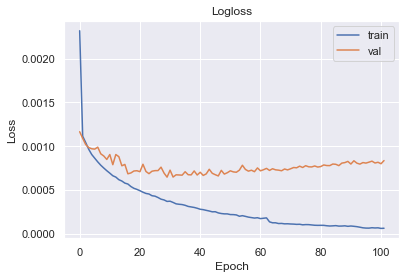

In [9]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5,1,'Lwlrap')

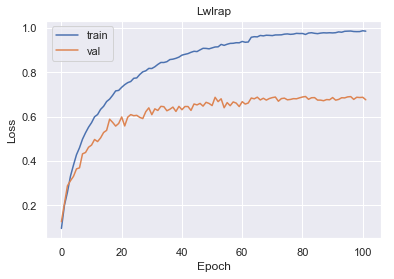

In [10]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')